Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

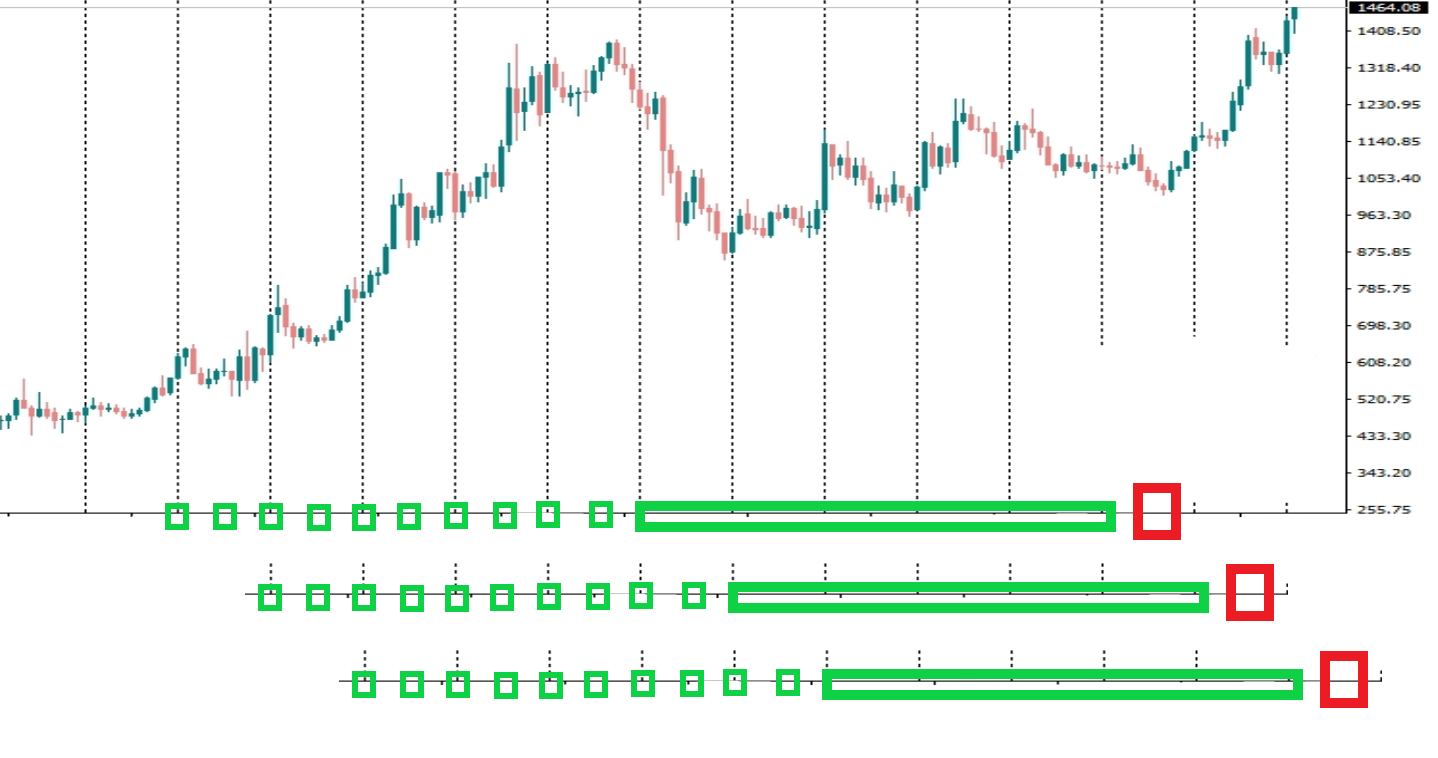

## Подготовка

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import (
    concatenate,
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten,
    Conv1D,
    LSTM,
    MaxPooling1D,
)

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

from keras.utils import Sequence

# Отключение предупреждений
import warnings

warnings.filterwarnings("ignore")

E0000 00:00:1747766940.585569  198876 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747766940.600415  198876 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [3]:
# Загрузка датасетов из облака

# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

In [4]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [5]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [6]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных
print(data.shape)

(481872, 5)


In [7]:
# Получение названий столбцов

col = data.columns
print(col)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [8]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME',
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3)
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True)
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)


In [9]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,...,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,...,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,...,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,...,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,...,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,...,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,...,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,...,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [10]:
# Использование всех столбцов, кроме первых двух
data = np.array(data.iloc[2:])

# Перевод в numpy
data = np.array(data)

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1]

In [11]:
class MultiStepGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size=256, seq_len=100):
        self.base_gen1 = TimeseriesGenerator(
            x_data,
            y_data,
            length=seq_len * 10,
            stride=1,
            sampling_rate=10,
            batch_size=batch_size,
        )
        self.base_gen2 = TimeseriesGenerator(
            x_data[seq_len * 10 - 9 :],
            y_data[seq_len * 10 - 9 :],
            length=seq_len,
            stride=1,
            sampling_rate=1,
            batch_size=batch_size,
        )
        self.batch_size = batch_size
        self.length = min(len(self.base_gen1), len(self.base_gen2))

    def _build_sequences(self, idx):
        x1, _ = self.base_gen1[idx]
        x2, y = self.base_gen2[idx]

        min_len = min(len(x1), len(x2))
        x1 = x1[:min_len]
        x2 = x2[:min_len]
        y  = y[:min_len]

        x = np.concatenate([x1, x2], axis=1)

        return x, y

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x, y_seq = self._build_sequences(idx)
        return np.array(x), np.array(y_seq)


In [12]:
x_data = data
y_data = data[:, 3]
y_data = y_data.reshape(-1, 1)

test_len = 30000
train_len = x_data.shape[0] - test_len

x_data_train, x_data_test = x_data[:train_len], x_data[train_len + 2 * 1090:]
y_data_train, y_data_test = y_data[:train_len], y_data[train_len + 2 * 1090:]


x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

In [13]:
train_gen = MultiStepGenerator(x_data_train, y_data_train)
val_gen = MultiStepGenerator(x_data_test, y_data_test)
print(f"Train batch x: {train_gen[0][0].shape}, y: {train_gen[0][1].shape}")
test_gen = MultiStepGenerator(x_data_test, y_data_test, batch_size=x_data_test.shape[0])

Train batch x: (256, 200, 50), y: (256, 1)


In [14]:
x_test, y_test = test_gen[0]

# Проверка формы тестовой выборки
print(f"Test x: {x_test.shape}, y: {y_test.shape}")


Test x: (26729, 200, 50), y: (26729, 1)


In [15]:
def get_pred(
    model,  # модель
    x_test,
    y_test,  # тестовая выборка
    y_scaler,
):  # масштабирующий объект для y
    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled


In [16]:
def show_predict(
    y_pred,
    y_true,  # прогноз данных и исходный ряд
    start,  # точка ряда, с которой начинается отрисовка графика
    length,  # количество точек для отрисовки графика
    chn_list=None,  # список каналов данных для отрисовки (по умолчанию все)
    chn_names=["Close"],  # список имен каналов данных
    title="",
):
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    if len(chn_list) != len(chn_names):
        chn_names = chn_list

    for chn in chn_list:
        plt.plot(y_pred[start : start + length, chn], label=f"{chn_names[chn]} Прогноз")
        plt.plot(y_true[start : start + length, chn], label=f"{chn_names[chn]} Базовый")

    plt.title(title)
    plt.xlabel("Время")
    plt.ylabel("Данные")
    plt.legend()
    plt.show()


In [17]:
def eval_net(
    model,  # модель
    x_test,
    y_test,  # тестовая выборка
    y_scaler,  # нормировщик выхода
    start=0,
    length=500,
    back_steps_max=30,  # параметры отображения графиков
    title="",
):
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    print(y_pred.shape, " - pred")
    print(y_true.shape, " - true")

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(
        y_pred[1:],
        y_true[:-1],
        start,
        length,
        title=f"{title}: Сопоставление базового и прогнозного рядов",
    )


In [18]:
def train_eval_net(
    model,  # модель
    train_datagen,
    val_datagen,  # генераторы обучающей и проверочной выборок
    epoch_list,  # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
    x_test,
    y_test,
    y_scaler,
    start=0,
    length=500,
    back_steps_max=30,
    title="",
):
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss="mse", optimizer=opt)
        # Фаза обучения модели
        print(f"Обучение {epochs} эпох")
        history = model.fit(
            train_datagen, epochs=epochs, validation_data=val_datagen, verbose=1
        )

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history["loss"], label="Ошибка на обучающем наборе")
        plt.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
        plt.title(f"{title}: График прогресса обучения")
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel("Эпоха обучения")
        plt.ylabel("Средняя ошибка")
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(
            model,
            x_test,
            y_test,
            y_scaler,
            start=start,
            length=length,
            back_steps_max=back_steps_max,
            title=title,
        )


I0000 00:00:1747766949.321864  198876 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 64)        │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,631 (135.28 KB)

 Trainable params: 34,631 (135.28 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 20 эпох
Epoch 1/20


I0000 00:00:1747766951.448161  198998 service.cc:148] XLA service 0x17aabf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747766951.449510  198998 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1747766951.805216  198998 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1761 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - loss: 0.1008 

I0000 00:00:1747766955.104382  198998 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1761/1761 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 0.0048 - val_loss: 3.1997e-06
Epoch 2/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 6.0938e-04 - val_loss: 2.2622e-06
Epoch 3/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.7659e-04 - val_loss: 2.6691e-05
Epoch 4/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 9.9430e-05 - val_loss: 1.3884e-05
Epoch 5/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 3.5801e-04 - val_loss: 6.8571e-05
Epoch 6/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 4.1928e-05 - val_loss: 2.6759e-06
Epoch 7/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 7.3229e-05 - val_loss: 6.0517e-05
Epoch 8/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 2.9845e-04 - val_loss: 1.5996e-06
Epoch 9/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 1.1354e-04 - val_loss: 1.9257e-05
Epoch 10/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 6.0841e-05 - val_loss: 3.3967e-06
Epoch 11/20
1761/1761 ━━━━━━━━━━━━

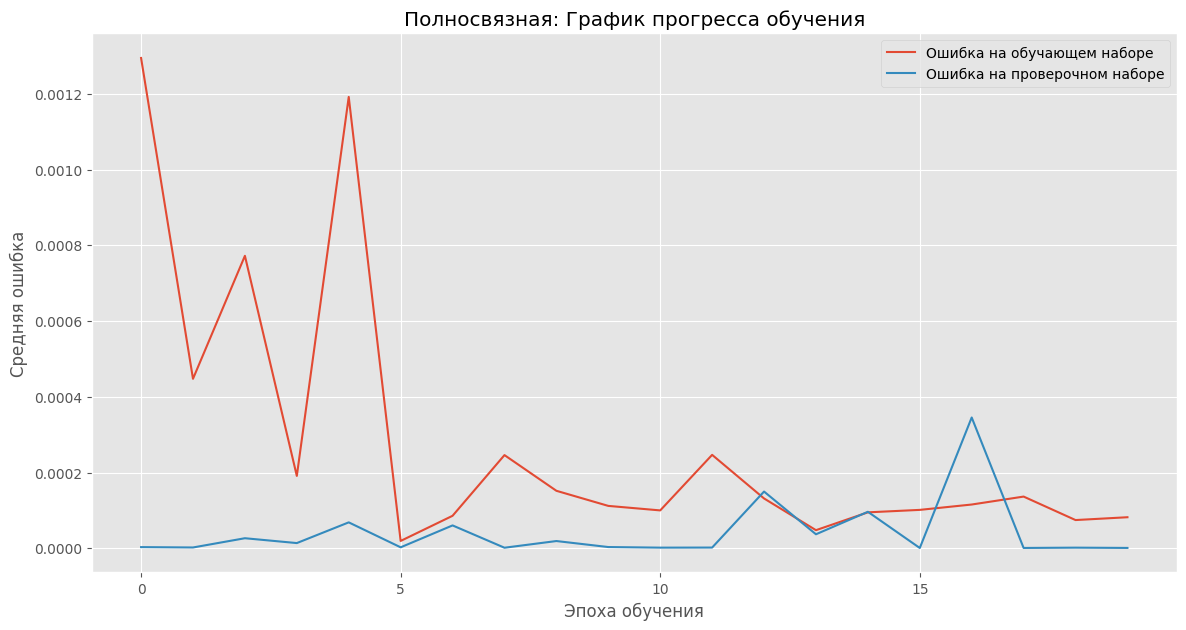

836/836 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
(26729, 1)  - pred
(26729, 1)  - true


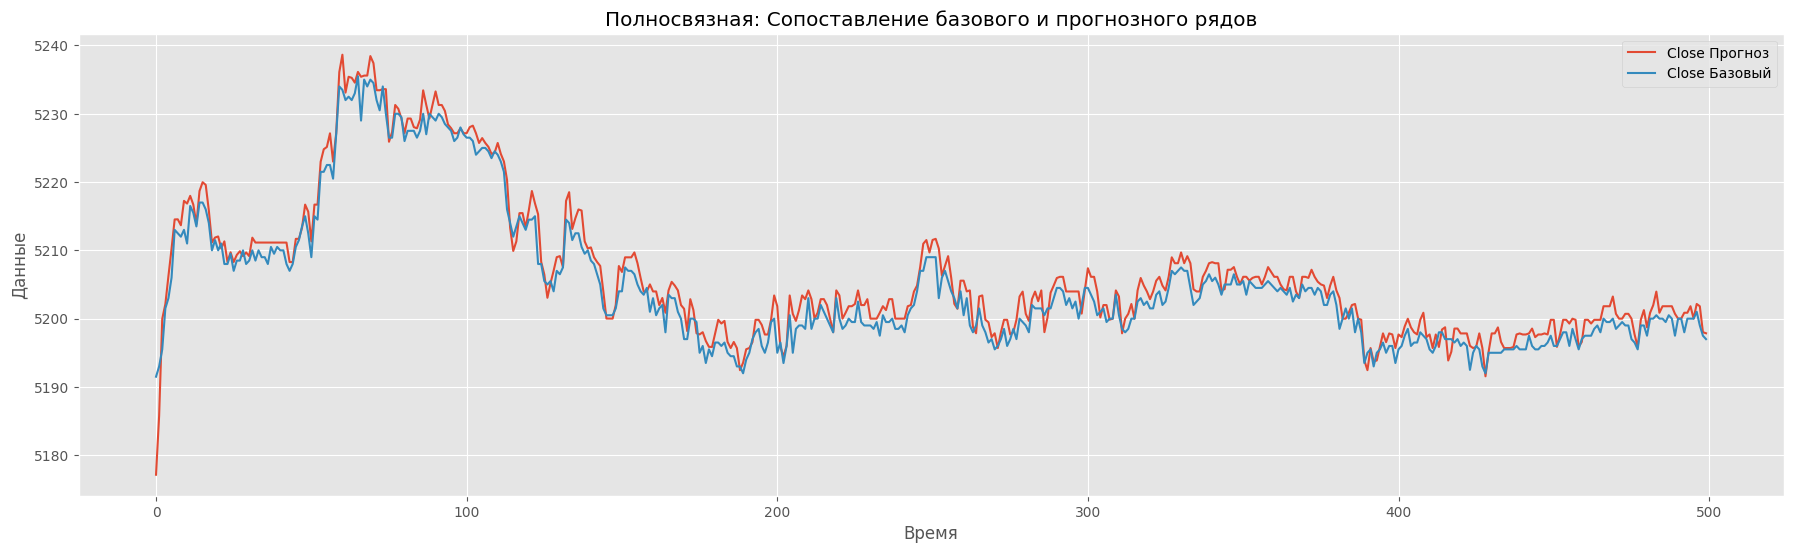

Обучение 20 эпох
Epoch 1/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - loss: 4.8187e-06 - val_loss: 1.2094e-06
Epoch 2/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.7286e-06 - val_loss: 1.6028e-06
Epoch 3/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.1711e-06 - val_loss: 1.0622e-05
Epoch 4/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 2.9213e-06 - val_loss: 8.5953e-07
Epoch 5/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 1.9581e-06 - val_loss: 1.1180e-06
Epoch 6/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.7448e-06 - val_loss: 1.0289e-06
Epoch 7/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 1.0745e-06 - val_loss: 8.9831e-07
Epoch 8/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 1.2708e-06 - val_loss: 8.7062e-07
Epoch 9/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 1.2577e-06 - val_loss: 1.5602e-06
Epoch 10/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 1.2798e-06 - val_loss: 8.5999e-07
Ep

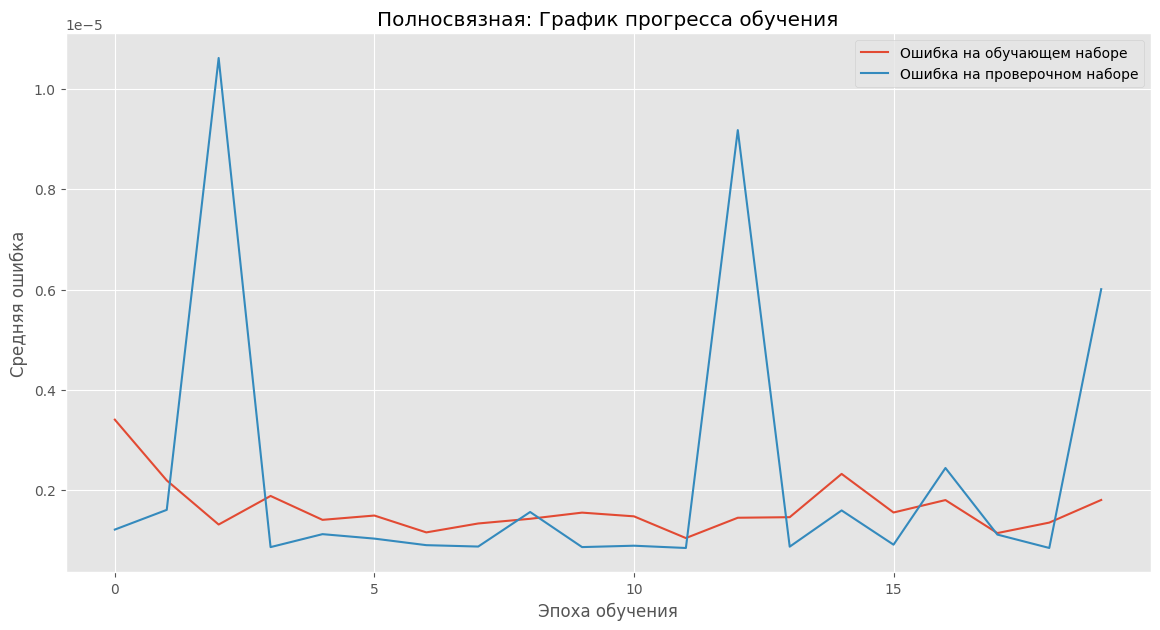

836/836 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
(26729, 1)  - pred
(26729, 1)  - true


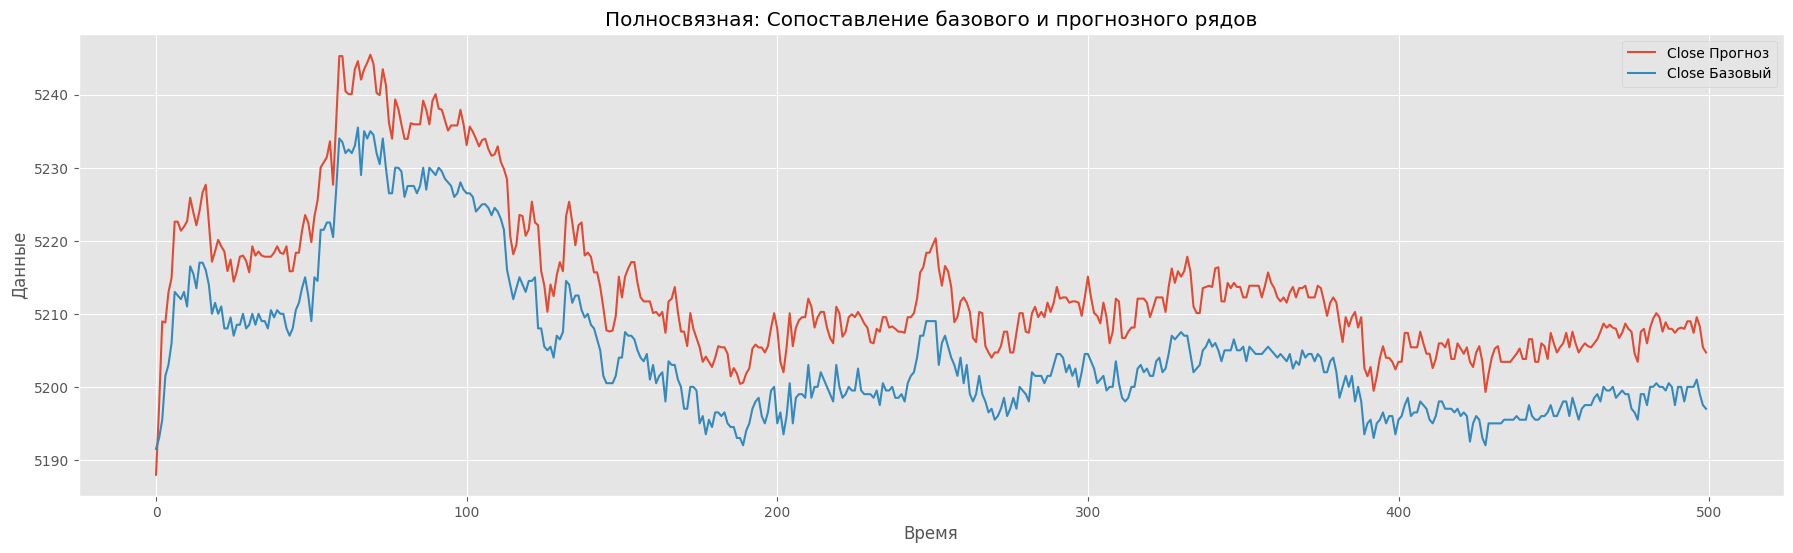

Обучение 20 эпох
Epoch 1/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 7.0488e-07 - val_loss: 8.4126e-07
Epoch 2/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 6.1618e-07 - val_loss: 8.3746e-07
Epoch 3/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 6.3841e-07 - val_loss: 8.3917e-07
Epoch 4/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 6.1997e-07 - val_loss: 8.6434e-07
Epoch 5/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 6.4305e-07 - val_loss: 8.3282e-07
Epoch 6/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 6.5451e-07 - val_loss: 8.5901e-07
Epoch 7/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 6.1906e-07 - val_loss: 8.8482e-07
Epoch 8/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 6.0950e-07 - val_loss: 8.2627e-07
Epoch 9/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 6.2088e-07 - val_loss: 9.8786e-07
Epoch 10/20
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 6.6979e-07 - val_loss: 8.2864e-07
Ep

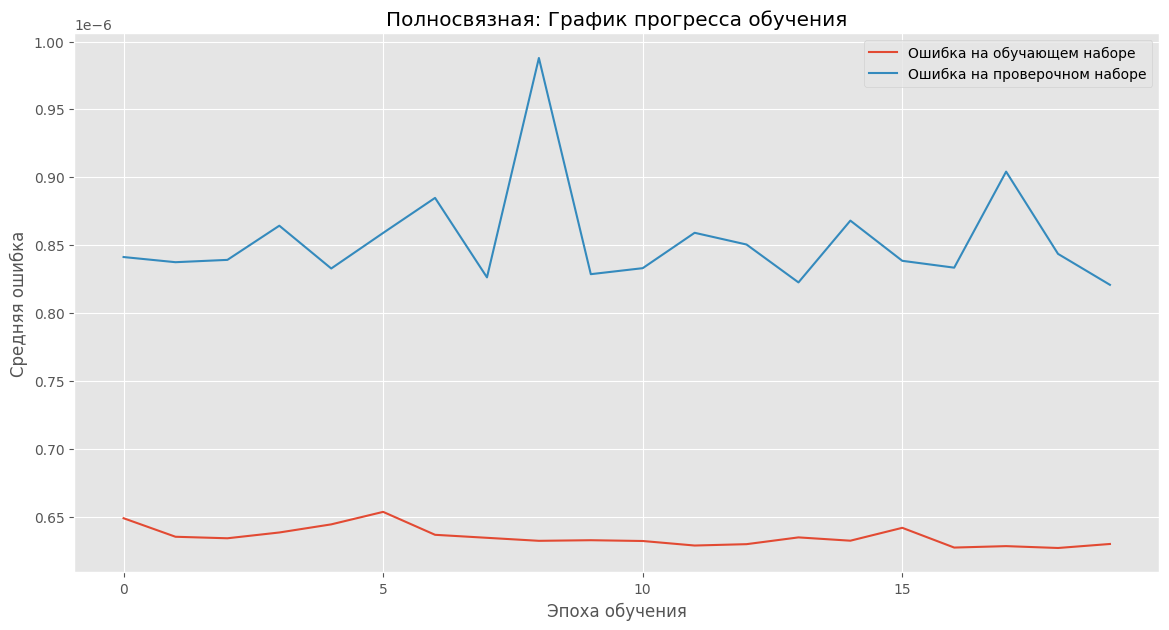

836/836 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
(26729, 1)  - pred
(26729, 1)  - true


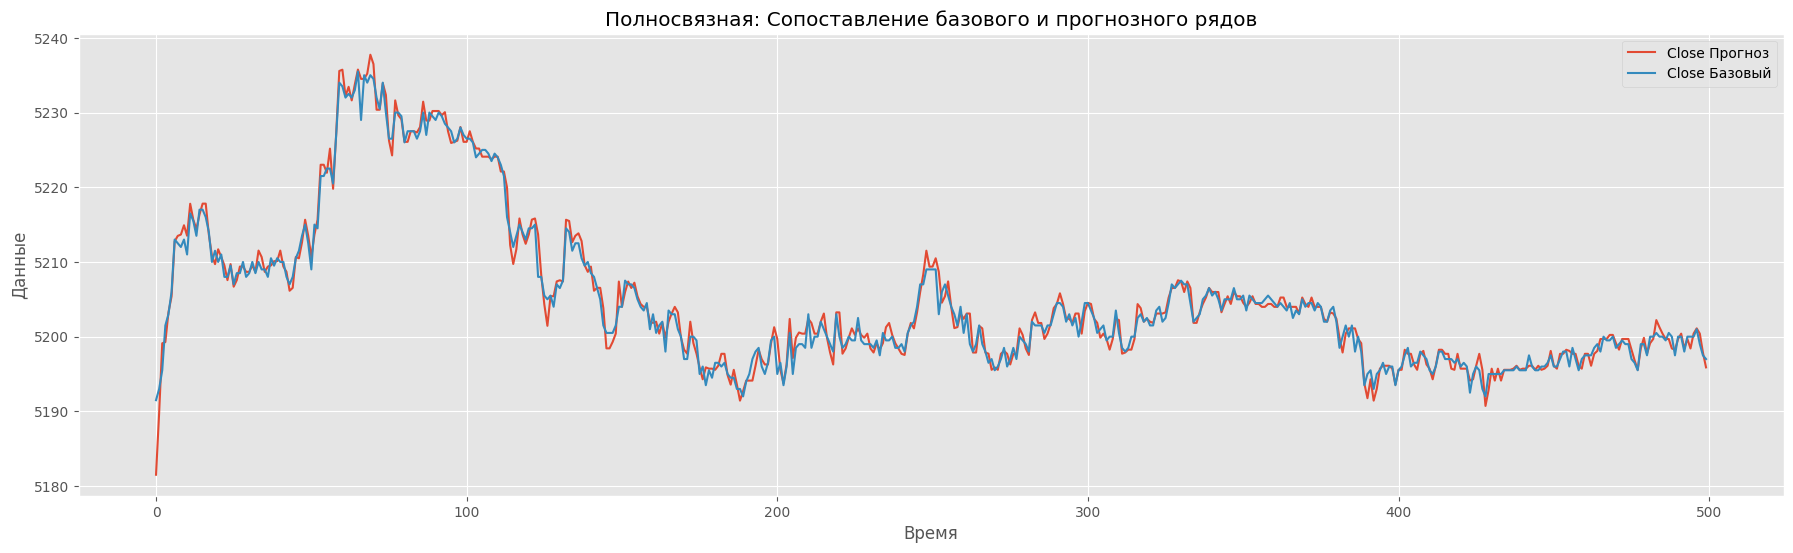

In [19]:
model_hybrid = Sequential(
    [
        Input(shape=x_test.shape[1:]),
        Conv1D(64, 3, activation="relu", padding="causal"),
        MaxPooling1D(pool_size=2),
        LSTM(32, activation="relu", return_sequences=False),
        Dense(150, activation="relu"),
        Dense(50, activation="relu"),
        Dense(y_test.shape[1], activation="linear"),
    ]
)
train_eval_net(
    model_hybrid,
    train_gen,
    val_gen,
    [
        (20, Adam(learning_rate=1e-3)),
        (20, Adam(learning_rate=1e-4)),
        (20, Adam(learning_rate=1e-5)),
    ],
    x_test,
    y_test,
    y_scaler,
    title="Полносвязная",
)